## Create a plot comparing the NN train size against the MAE of the validation and train set

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from collections import defaultdict
import numpy as np
import h5py
import keras_core as keras
import tensorflow_io as tfio
from tensorflow.data import Dataset
from tensorflow.data.experimental import AUTOTUNE
import sys
sys.path.append('../../scripts/')
import utils as utils
from preprocess import transform_input, untransform_input, RIGIDITY_VALS, INPUTS

2025-04-09 10:21:58.561276: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-09 10:21:59.953570: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-09 10:21:59.957056: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-09 10:22:05.442073: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Using TensorFlow backend


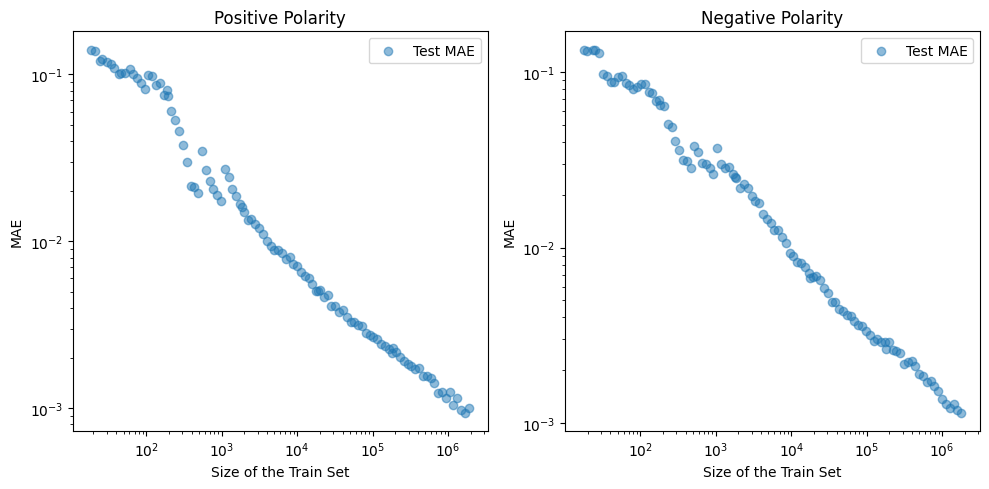

In [14]:
# Load data from csv: train_size, train_mae, val_mae
dir = '../../models/model_size_investigation'
pos = np.loadtxt(f'{dir}/pos.csv', delimiter=',')
neg = np.loadtxt(f'{dir}/neg.csv', delimiter=',')

pos[:, 0] = pos[:, 0] * 1_879_546
neg[:, 0] = neg[:, 0] * 1_788_892

# Plot the train size against the train and validation mae
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
# plt.scatter(pos[:, 0], pos[:, 1], alpha=0.5, label='Train MAE')
plt.scatter(pos[:, 0], pos[:, 2], alpha=0.5, label='Test MAE')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Size of the Train Set')
plt.ylabel('MAE')
plt.title('Positive Polarity')
plt.legend()

plt.subplot(1, 2, 2)
# plt.scatter(neg[:, 0], neg[:, 1], alpha=0.5, label='Train MAE')
plt.scatter(neg[:, 0], neg[:, 2], alpha=0.5, label='Test MAE')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Size of the Train Set')
plt.ylabel('MAE')
plt.title('Negative Polarity')
plt.legend()

plt.tight_layout()
plt.savefig(f'{dir}/all_models_size_vs_mae.png')
plt.show()

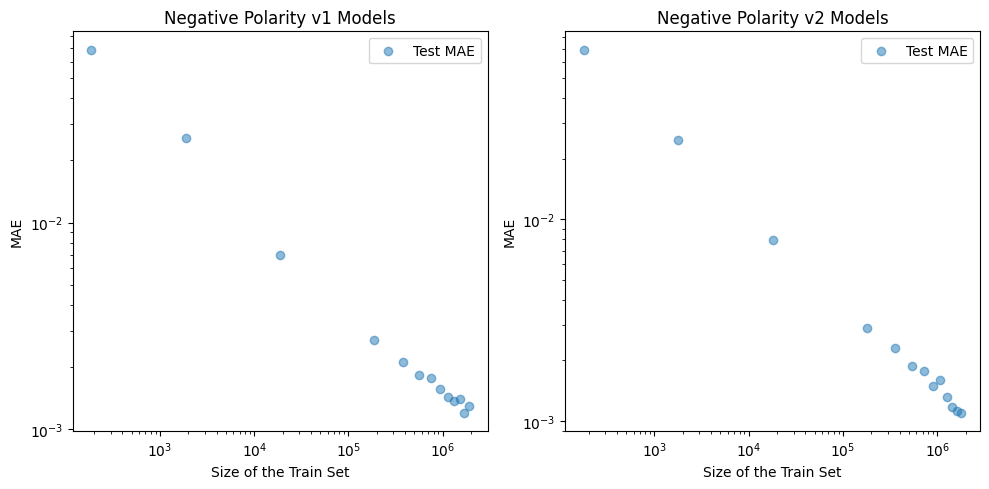

In [26]:
# Load data from csv: train_size, train_mae, val_mae
dir = '../../models/model_size_investigation'
neg1 = np.loadtxt(f'{dir}/v3_neg.csv', delimiter=',')
neg2 = np.loadtxt(f'{dir}/v4_neg.csv', delimiter=',')

neg1[:, 0] = neg1[:, 0] * 1_879_546
neg2[:, 0] = neg2[:, 0] * 1_788_892

# Plot the train size against the train and validation mae
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(neg1[:, 0], neg1[:, 2], alpha=0.5, label='Test MAE')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Size of the Train Set')
plt.ylabel('MAE')
plt.title('Negative Polarity v1 Models')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(neg2[:, 0], neg2[:, 2], alpha=0.5, label='Test MAE')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Size of the Train Set')
plt.ylabel('MAE')
plt.title('Negative Polarity v2 Models')
plt.legend()

plt.tight_layout()
plt.savefig(f'{dir}/all_models_size_vs_mae_v1v2.png')
plt.show()

## Load data and analyze distribution

In [16]:
polarity = 'neg'
train_size_fraction = 0.1
model_version = 'v3'
data_path = '/home/linneamw/sadow_koastore/personal/linneamw/research/gcr/data/2023_07_01'
data_file = f'{data_path}/neg/model_collection_1AU_90deg_0deg_fixed_training.h5'

# 8 input parameters for the NN: alpha, cmf, vspoles, cpa, pwr1par, pwr2par, pwr1perr, and pwr2perr.
# features = ['alpha', 'cmf', 'cpa', 'pwr1par', 'pwr1perr', 'pwr2par', 'pwr2perr', 'vspoles']
with h5py.File(data_file, 'r') as h5:
    num_samples, num_inputs,  = h5['X_minmax'].shape
    _, num_flux,  = h5['Y_log_scaled'].shape
x = tfio.IODataset.from_hdf5(data_file, dataset='/X_minmax')
y = tfio.IODataset.from_hdf5(data_file, dataset='/Y_log_scaled')

# Split
full = Dataset.zip((x, y))
full_train = full.take(np.floor(num_samples *.9)) # Keep train set we sample from consistent as 90% of the data
test = full.skip(np.floor(num_samples *.9)) # Keep test set consistent as 10% of the data

# Reduce train size based on the train_size_fraction
train_size = np.floor(num_samples *.9 * train_size_fraction)
if model_version == 'v1':
    train_shuffled = full_train.shuffle(buffer_size=full_train.cardinality(), seed=42)
elif model_version == 'v2':
    train_shuffled = full_train.shuffle(buffer_size=full_train.cardinality(), seed=87)
else:
    train_shuffled = full_train

train = train_shuffled.take(train_size)

# Batch test/validation set
batch_size = 128
train = train.batch(batch_size, drop_remainder=True).prefetch(AUTOTUNE)
train_steps = int(train_size / batch_size)
test = test.batch(batch_size, drop_remainder=True).prefetch(AUTOTUNE)
validation_steps = int(num_samples * .1 / batch_size)

print(f'Train steps: {train_steps}')
print(f'Validation steps: {validation_steps}')

Train steps: 1397
Validation steps: 1552


In [17]:
# Convert test sets to numpy arrays
test_x = []
test_y = []
for batch in test:
    x, y = batch
    test_x.append(x)
    test_y.append(y)

test_x = np.array(test_x)
test_y = np.array(test_y)

# Collapse middle dimension of test_x
test_x = np.concatenate(test_x, axis=0)  # Flatten along the batch dimension
test_y = np.concatenate(test_y, axis=0)  # Flatten along the batch dimension
print(f'Test set x shape after collapsing: {test_x.shape}')
print(f'Test set y shape after collapsing: {test_y.shape}')

# Convert train set to numpy arrays
train_x = []
train_y = []
for batch in train:
    x, y = batch
    train_x.append(x)
    train_y.append(y)
train_x = np.array(train_x)
train_y = np.array(train_y)

train_x = np.concatenate(train_x, axis=0)  # Flatten along the batch dimension
train_y = np.concatenate(train_y, axis=0)  # Flatten along the batch dimension
print(f'Train set x shape after collapsing: {train_x.shape}')
print(f'Train set y shape after collapsing: {train_y.shape}')

Test set x shape after collapsing: (198656, 8)
Test set y shape after collapsing: (198656, 32)
Train set x shape after collapsing: (178816, 8)
Train set y shape after collapsing: (178816, 32)


In [18]:
# Print first 10 values of train_x and train_y
print('Train x:', train_x[:10])
print('Train y:', train_y[:10])

Train x: [[0.11764706 0.         0.53246754 0.2307692  0.         0.6842106
  0.3157895  0.        ]
 [0.23529412 0.         0.53246754 1.         0.46153846 0.15789473
  0.6842106  0.33333334]
 [0.88235295 0.5        0.37662336 0.69230765 0.46153846 0.15789473
  0.6842106  1.        ]
 [0.11764706 0.5714286  0.6883117  1.         0.2307692  1.
  0.6842106  0.6666667 ]
 [1.         0.42857143 0.6883117  0.         0.2307692  0.15789473
  0.4736842  0.        ]
 [0.3529412  0.5714286  0.84415585 0.         0.         1.
  0.3157895  0.6666667 ]
 [0.88235295 0.14285715 0.37662336 0.         0.69230765 0.4736842
  0.6842106  0.33333334]
 [0.11764706 0.2857143  1.         0.         0.         0.3157895
  0.         0.33333334]
 [0.23529412 0.85714287 0.22077923 1.         0.46153846 0.3157895
  0.6842106  0.        ]
 [0.7647059  0.85714287 1.         1.         0.2307692  0.15789473
  0.15789473 0.6666667 ]]
Train y: [[ 0.8429651   0.8452625   0.8498036   0.8564795   0.8672354   0.879512

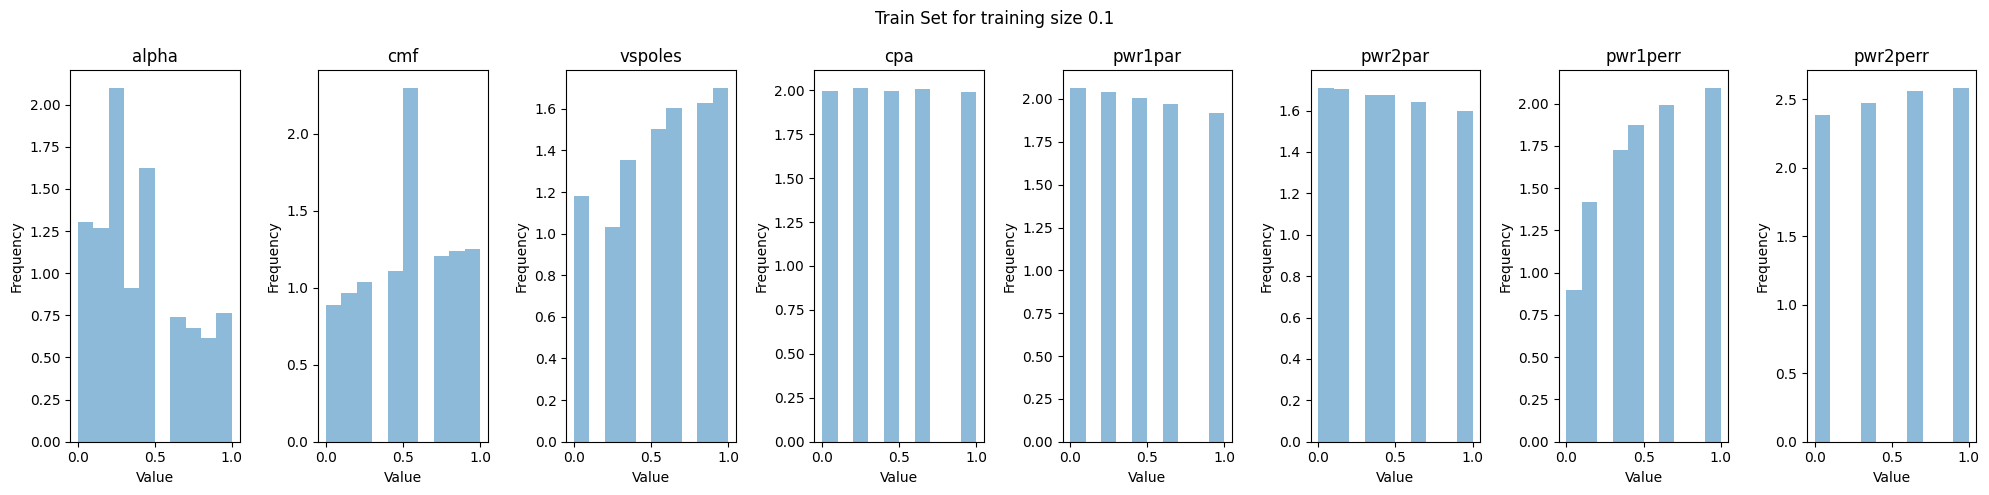

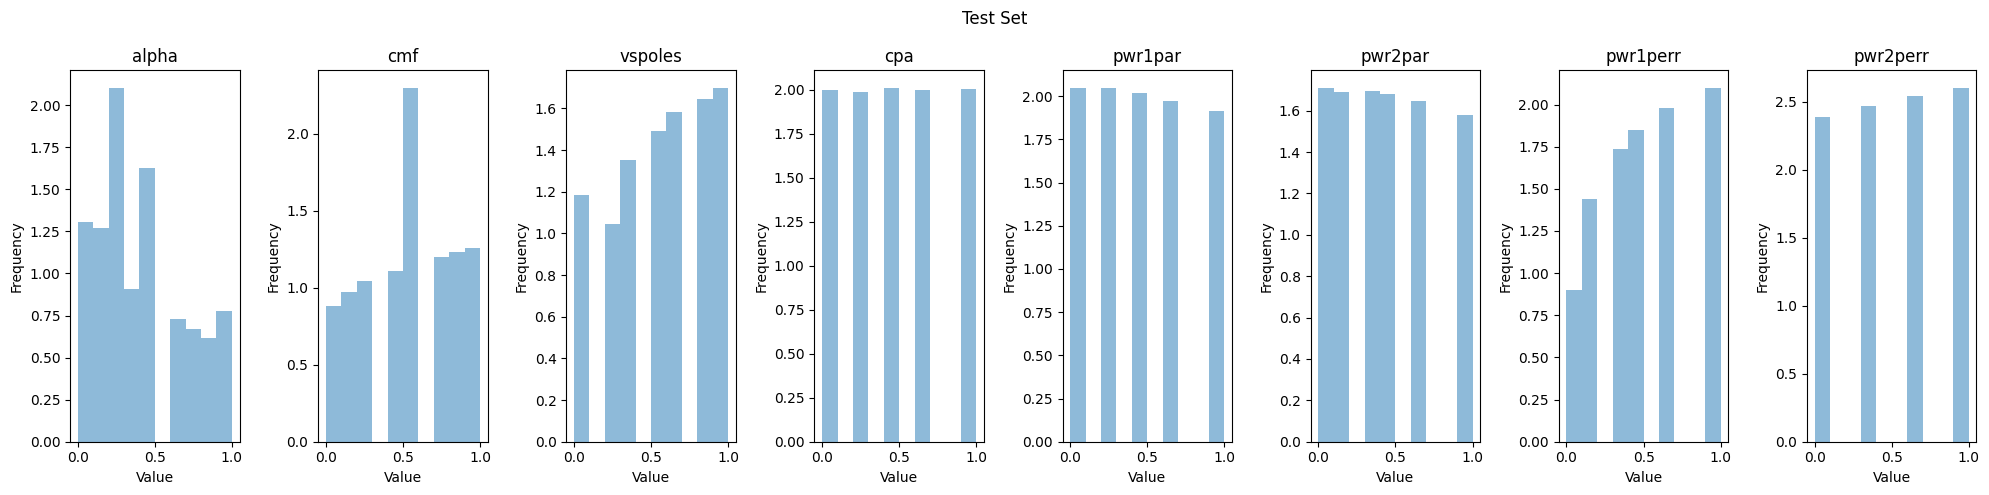

In [19]:
# Plot the distribution of the input parameters in the full_train and test sets
data_names = ['alpha', 'cmf', 'vspoles', 'cpa', 'pwr1par', 'pwr2par', 'pwr1perr', 'pwr2perr']

# Plot histograms of the 8 input parameters for the train and test sets
plt.figure(figsize=(20, 5))
plt.suptitle(f'Train Set for training size {train_size_fraction}')

# Loop through each of the 8 features and plot the histograms
for i in range(8):
    # Create the subplot
    plt.subplot(1, 8, i + 1)
    plt.hist(train_x[:, i], alpha=0.5, density=True)
    plt.title(data_names[i])
    plt.xlabel('Value')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Plot histograms of the 8 input parameters for the train and test sets
plt.figure(figsize=(20, 5))
plt.suptitle('Test Set')

# Loop through each of the 8 features and plot the histograms
for i in range(8):
    # Create the subplot
    plt.subplot(1, 8, i + 1)
    plt.hist(test_x[:, i], alpha=0.5, density=True)
    plt.title(data_names[i])
    plt.xlabel('Value')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

## Evaluate MAE on the test set
Create plot for Claudio: plot the error of the samples in the validation set, but grouped by the values those samples took for each parameter.

In [20]:
polarity = 'neg'
train_size_fraction = 0.5
model_version = 'v1'
data_path = '/home/linneamw/sadow_koastore/personal/linneamw/research/gcr/data/2023_07_01'
data_file = f'{data_path}/neg/model_collection_1AU_90deg_0deg_fixed_training.h5'

# 8 input parameters for the NN: alpha, cmf, vspoles, cpa, pwr1par, pwr2par, pwr1perr, and pwr2perr.
# features = ['alpha', 'cmf', 'cpa', 'pwr1par', 'pwr1perr', 'pwr2par', 'pwr2perr', 'vspoles']
with h5py.File(data_file, 'r') as h5:
    num_samples, num_inputs,  = h5['X_minmax'].shape
    _, num_flux,  = h5['Y_log_scaled'].shape
x = tfio.IODataset.from_hdf5(data_file, dataset='/X_minmax')
y = tfio.IODataset.from_hdf5(data_file, dataset='/Y_log_scaled')

# Split
full = Dataset.zip((x, y))
full_train = full.take(np.floor(num_samples *.9)) # Keep train set we sample from consistent as 90% of the data
test = full.skip(np.floor(num_samples *.9)) # Keep test set consistent as 10% of the data

# Reduce train size based on the train_size_fraction
train_size = np.floor(num_samples *.9 * train_size_fraction)
if model_version == 'v1':
    train_shuffled = full_train.shuffle(buffer_size=full_train.cardinality(), seed=42)
elif model_version == 'v2':
    train_shuffled = full_train.shuffle(buffer_size=full_train.cardinality(), seed=87)
else:
    train_shuffled = full_train

train = train_shuffled.take(train_size)

# Batch test/validation set
batch_size = 128
train = train.batch(batch_size, drop_remainder=True).prefetch(AUTOTUNE)
train_steps = int(train_size / batch_size)
test = test.batch(batch_size, drop_remainder=True).prefetch(AUTOTUNE)
validation_steps = int(num_samples * .1 / batch_size)

print(f'Train steps: {train_steps}')
print(f'Validation steps: {validation_steps}')

Train steps: 6987
Validation steps: 1552


In [21]:
# Load model
model_path = f'../../models/model_size_investigation/model_{model_version}_train_size_{train_size_fraction}_{polarity}.keras'  # Must end with keras.
model = keras.models.load_model(model_path)

print(f"Model: {model_path}. Predicting...")

# Predict on the train and test sets
test_pred = model.predict(test, steps=validation_steps+1)

# Calculate MAE on test set
test_mae = model.evaluate(test, steps=validation_steps+1)
print(f'Test MAE: {test_mae}')

Model: ../../models/model_size_investigation/model_v1_train_size_0.5_neg.keras. Predicting...


1553/1553 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
1553/1553 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0017
Test MAE: 0.0016560083022341132


In [22]:
# Extract all validation set features and labels
test_x = []
test_y = []

for batch in test:
    x, y = batch
    test_x.append(x.numpy())  # Convert tensors to numpy arrays
    test_y.append(y.numpy())

# Convert lists to single numpy arrays
test_x = np.concatenate(test_x, axis=0)  # Shape: (num_samples, 8)
test_y = np.concatenate(test_y, axis=0)  # Shape: (num_samples, 32)

print(test_pred.shape)
print(test_y.shape)

(198656, 32)
(198656, 32)


In [23]:
def group_and_compute_mae_dynamic(feature_idx, test_x, test_y, test_pred):
    """
    Groups data by unique values of a feature (after untransforming) and computes MAE for each output dimension.

    Parameters:
    - feature_idx (int): Index of the feature in test_x to group by.
    - test_x (ndarray): Input test data (min-max scaled).
    - test_y (ndarray): True labels (log scaled).
    - test_pred (ndarray): Predicted labels (log scaled).

    Returns:
    - dict: Keys are untransformed unique feature values, values are MAE arrays (shape: (32,))
    """
    # Untransform the selected input feature
    test_x_untrans = untransform_input(test_x)
    unique_values = np.unique(test_x_untrans[:, feature_idx])

    grouped_mae = {}

    for value in unique_values:
        # Find indices where the feature value matches
        indices = np.where(test_x_untrans[:, feature_idx] == value)[0]

        if len(indices) == 0:
            continue  # Skip if no matching samples

        # Compute MAE for each rigidity value (32 outputs)
        mae = np.mean(np.abs(test_y[indices] - test_pred[indices]), axis=0)

        # Store results
        grouped_mae[value] = mae

    return grouped_mae

# Function to compute MAE
def compute_mae_per_output(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred), axis=0)  # Shape: (32,)

# Example usage:
feature_idx = 7  # Index of v_sw in test_x
mae_results = group_and_compute_mae_dynamic(feature_idx, test_x, test_y, test_pred)
for value, mae in mae_results.items():
    print(f"v_sw = {value}: MAE per rigidity value = {mae}")

# Compute full dataset MAE
full_mae = compute_mae_per_output(test_y, test_pred)
print(f"Full dataset MAE: {full_mae}")

v_sw = 400.0: MAE per rigidity value = [0.00209332 0.00213903 0.00216757 0.00209015 0.00212926 0.00211176
 0.00209003 0.002092   0.00202891 0.00203827 0.00202322 0.00203761
 0.00193202 0.00189569 0.00181516 0.00179277 0.00171109 0.0018415
 0.00155309 0.00142068 0.00113953 0.00099495 0.00090214 0.00089312
 0.00080629 0.0007377  0.00085563 0.00083319 0.00076758 0.00079745
 0.00082767 0.0005591 ]
v_sw = 500.00000298023224: MAE per rigidity value = [0.00176803 0.00176528 0.00182248 0.00177461 0.00178536 0.00175195
 0.00175574 0.00177003 0.00170151 0.00170024 0.001683   0.00167293
 0.00161498 0.00159341 0.00151194 0.0014647  0.00142092 0.00145827
 0.00130507 0.00118293 0.00097015 0.00087464 0.0007915  0.00080934
 0.00071261 0.00065583 0.00075291 0.00075222 0.00072379 0.00076694
 0.00074054 0.00048982]
v_sw = 600.0000059604645: MAE per rigidity value = [0.0017185  0.0017439  0.0017442  0.00171017 0.00172462 0.00166778
 0.0016621  0.00166966 0.00158263 0.00159207 0.00158021 0.00156068
 0.0015

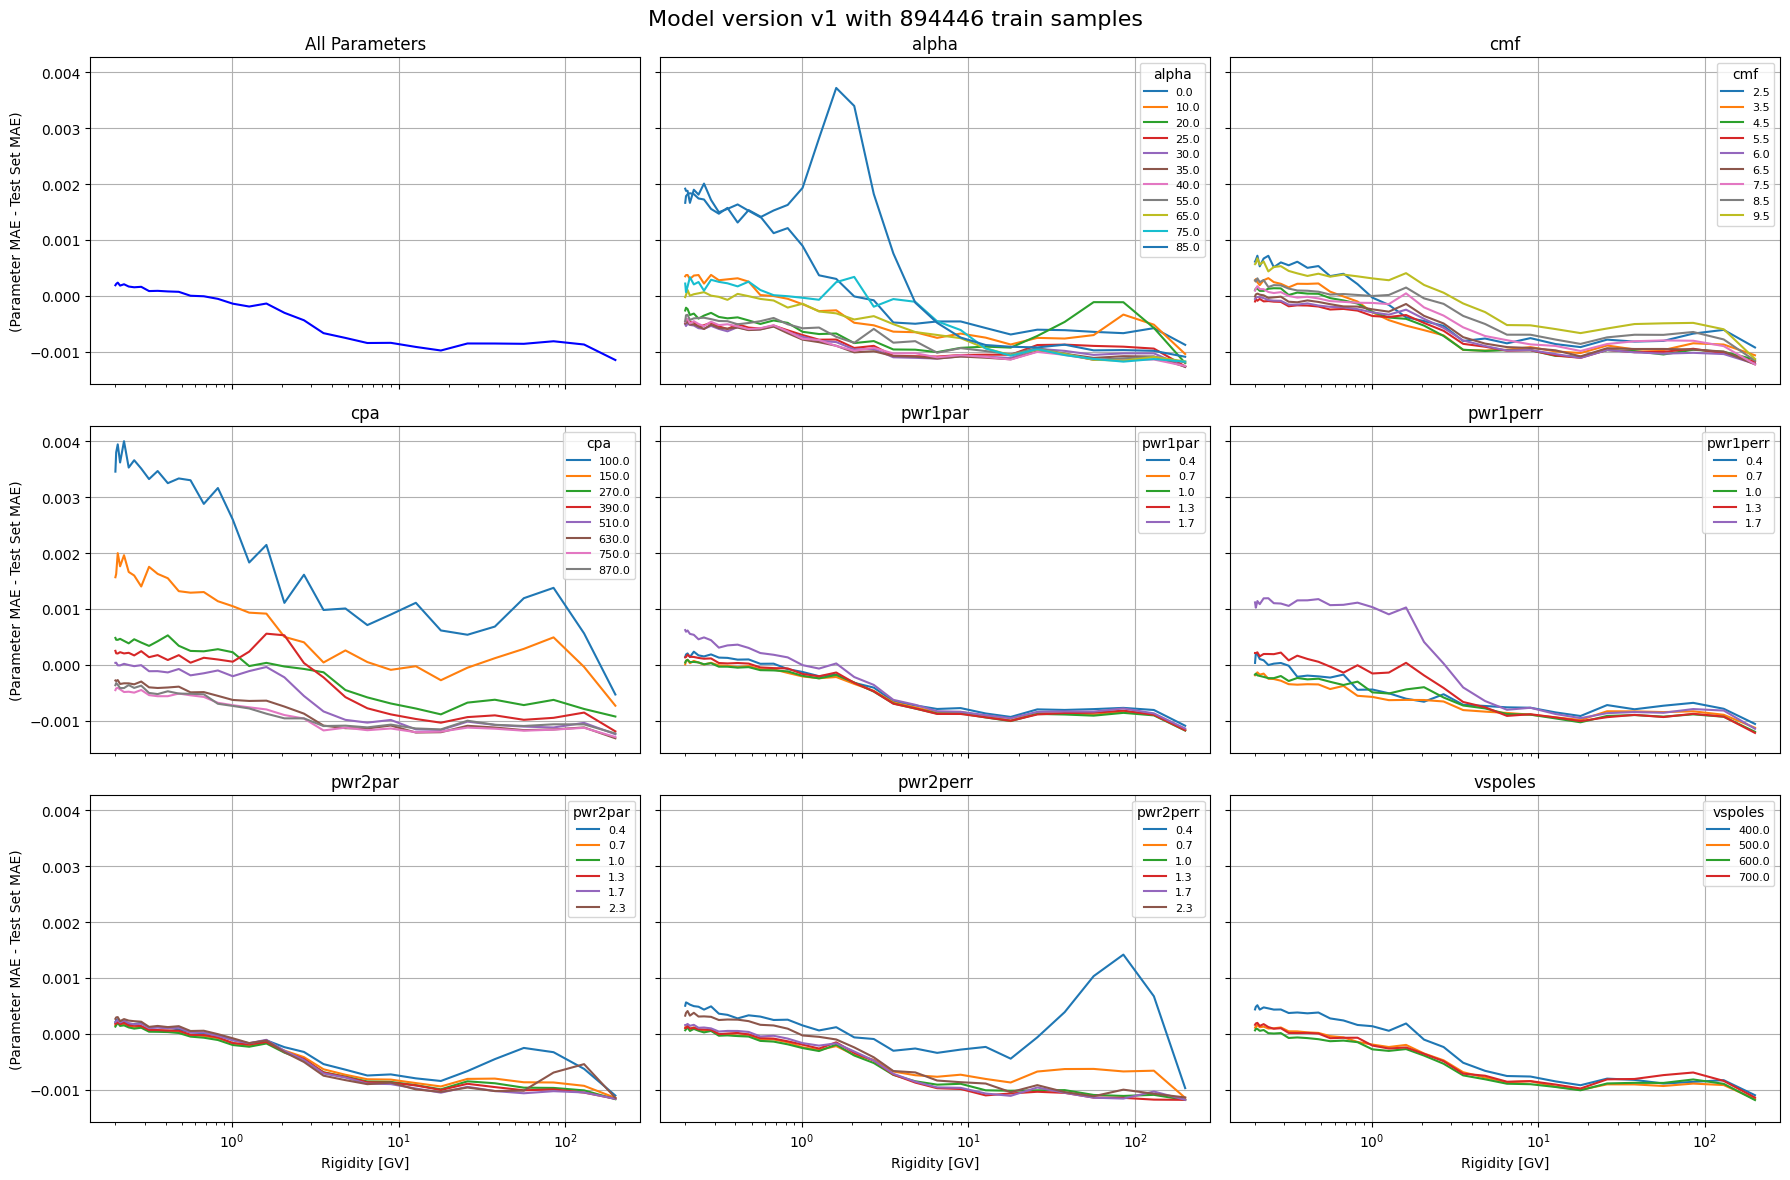

In [24]:
# Compute full dataset MAE (shape: (32,))
full_mae = compute_mae_per_output(test_y, test_pred)
full_diff = full_mae - test_mae

# Create the 3x3 plot grid
fig, axes = plt.subplots(3, 3, figsize=(18, 12), sharex=True, sharey=True)
plt.suptitle(f"Model version {model_version} with {int(train_size_fraction * 1_788_892)} train samples", fontsize=16)
axes = axes.flatten()

# Top-left plot (full MAE)
axes[0].plot(RIGIDITY_VALS, full_diff, color='blue')
axes[0].set_title("All Parameters")
axes[0].set_xlabel("Rigidity [GV]")
axes[0].set_ylabel("(Parameter MAE - Test Set MAE)")
axes[0].grid(True)
axes[0].set_xscale('log')

# Loop through each parameter and plot grouped MAE
test_x_untrans = untransform_input(test_x)

for i in range(8):
    ax = axes[i + 1]
    feature_idx = i

    # Group and compute MAE
    mae_results = group_and_compute_mae_dynamic(feature_idx, test_x, test_y, test_pred)

    # Plot each unique value's MAE
    for value, mae in mae_results.items():
        # Calculate difference from full MAE
        curr_diff = mae - test_mae

        # Plot
        ax.plot(RIGIDITY_VALS, curr_diff, label=f'{value:.1f}')

    ax.set_title(f"{INPUTS[i]}")
    ax.set_xlabel("Rigidity [GV]")
    ax.set_ylabel("(Parameter MAE - Test Set MAE)")
    ax.legend(title=INPUTS[i], fontsize=8)
    ax.grid(True)
    ax.set_xscale('log')

# Only label outer plots
for ax in axes:
    ax.label_outer()

plt.tight_layout()
plt.savefig(f'../../../results/v27/plots/{model_version}_{train_size_fraction}_NN_mae_test_diff_{polarity}.png', dpi=300)
plt.show()